# DSCI 100 Group Project Proposal

Team: Nicolas Mercuri, Tayler Whitehead, Chris Lukita, Stephanie Song

## Part 1: Introduction

Music plays a huge role in our experience of the world around us. Daily tasks like walking through campus, completing homework assignments, or simply cooking dinner after a long day, is a lot more enjoable while listening to your favourite song or playlist.

For our group project this semester, we decided to work with a dataset called [Spotify Tracks DB](https://tinyurl.com/3dnwcpe2). This dataset was downloaded from Kaggle.com and was parsed using Spotify's official API. The dataset has over 230,000 unique observations (tracks) and features 18 relevant variables, each describing a specific qualitative or quantitative characteristic of a track.

For our predictive question, we are hoping to determine if specific quantitative characteristics of a track (daceability, energy, duration (ms)) can help predict a new song's populatiry on Spotify.

## Part 2: Preliminary Exploratory Data Analysis

### Reading in Raw Data + Getting Random Sample for Vizualizations

In [2]:
library(tidyverse)
library(repr)

options(repr.plot.width= 10, repr.plot.height= 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [12]:
spotify_raw_data = read_csv("https://raw.githubusercontent.com/chrislukita/DSCI100-Group-Final/main/data/SpotifyDataset.csv")

spotify_rs = spotify_raw_data %>%
            slice_sample(n = 1000)

Parsed with column specification:
cols(
  genre = col_character(),
  artist_name = col_character(),
  track_name = col_character(),
  track_id = col_character(),
  popularity = col_double(),
  acousticness = col_double(),
  danceability = col_double(),
  duration_ms = col_double(),
  energy = col_double(),
  instrumentalness = col_double(),
  key = col_character(),
  liveness = col_double(),
  loudness = col_double(),
  mode = col_character(),
  speechiness = col_double(),
  tempo = col_double(),
  time_signature = col_character(),
  valence = col_double()
)

Warning message:
“1 parsing failure.
   row col   expected     actual                                                                                             file
115177  -- 18 columns 15 columns 'https://raw.githubusercontent.com/chrislukita/DSCI100-Group-Final/main/data/SpotifyDataset.csv'
”


### Cleaning and Wrangling Data

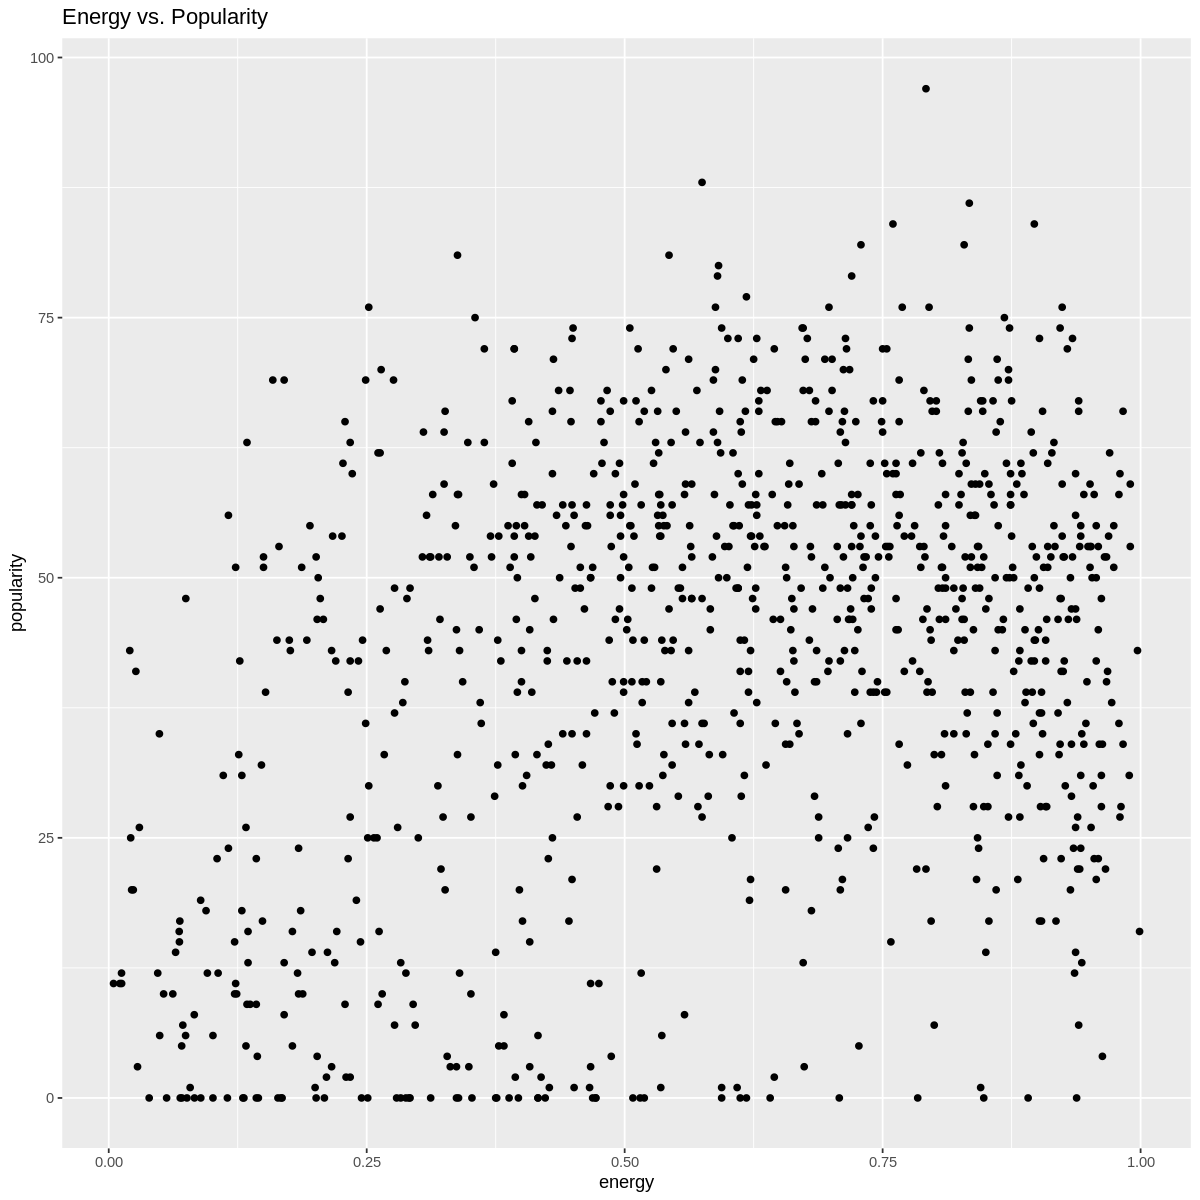

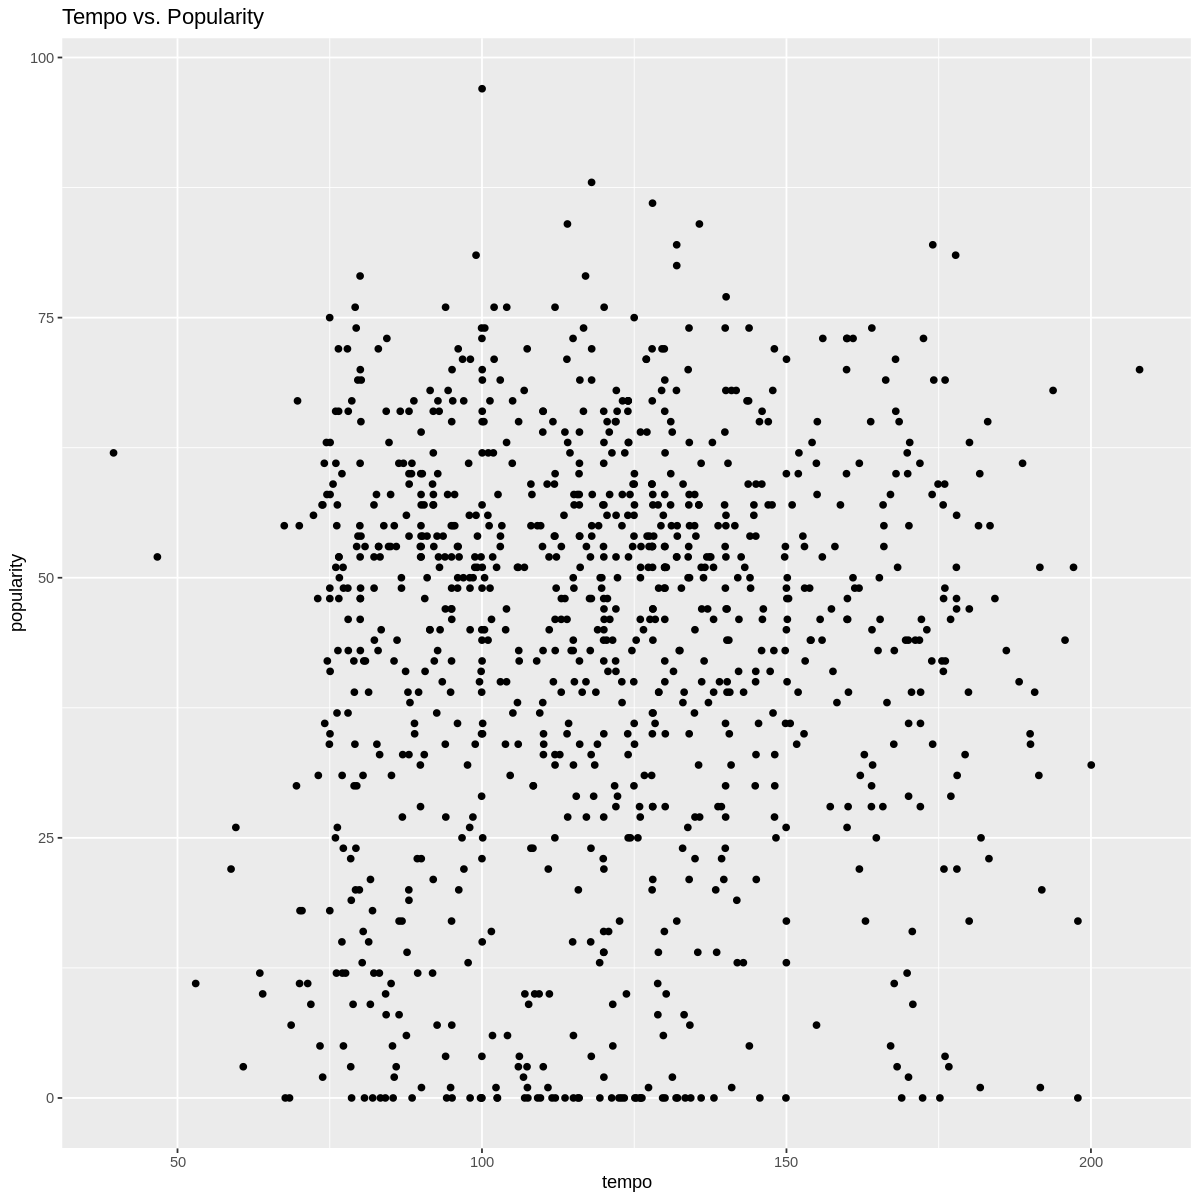

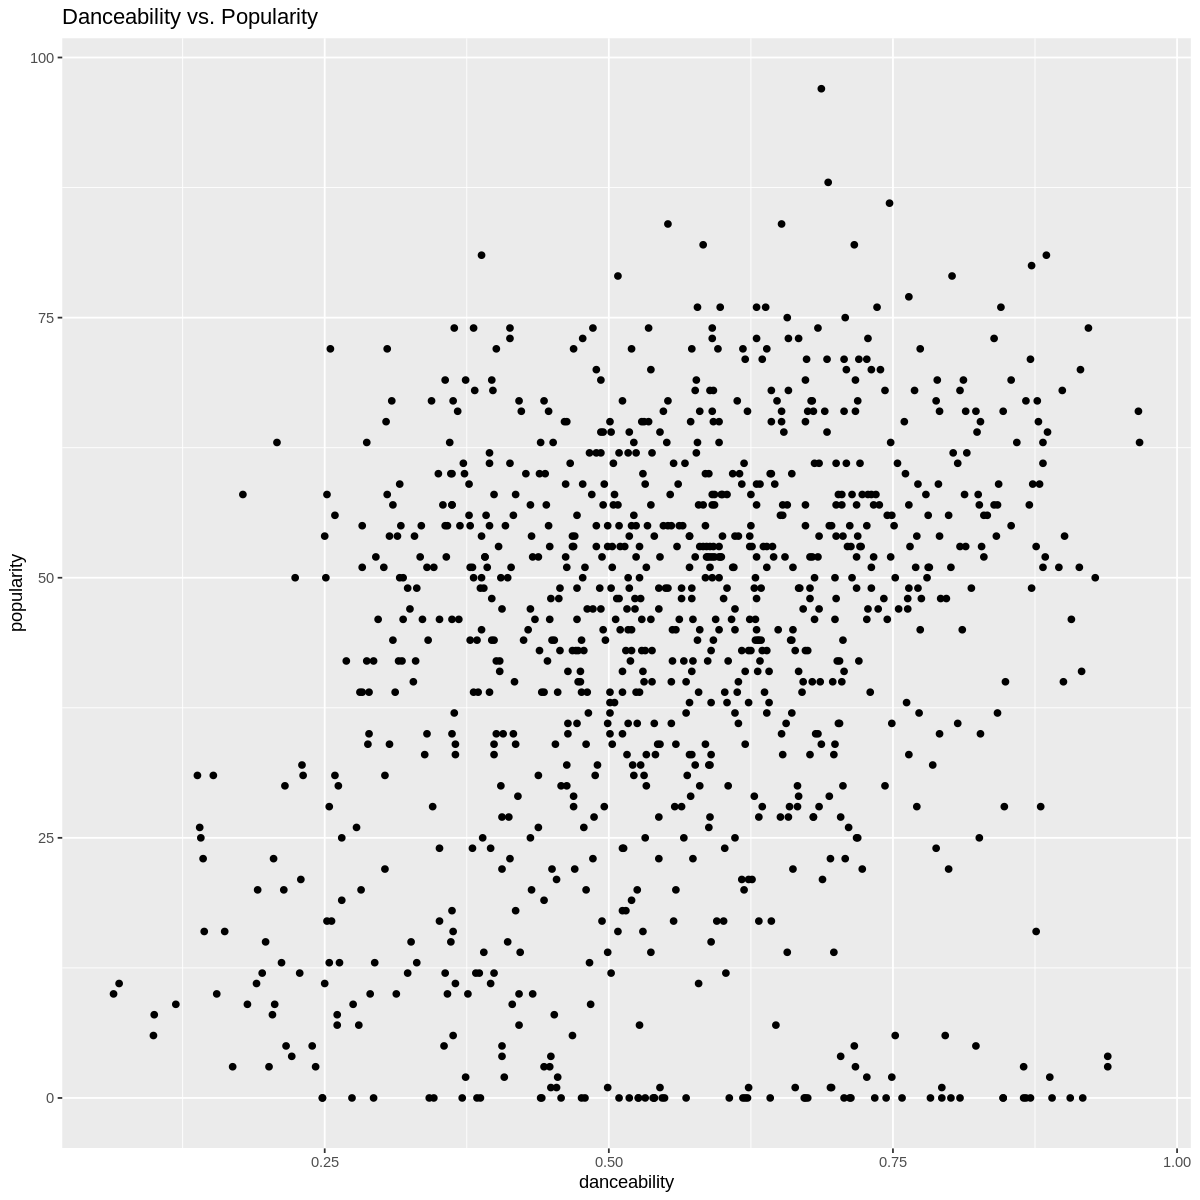

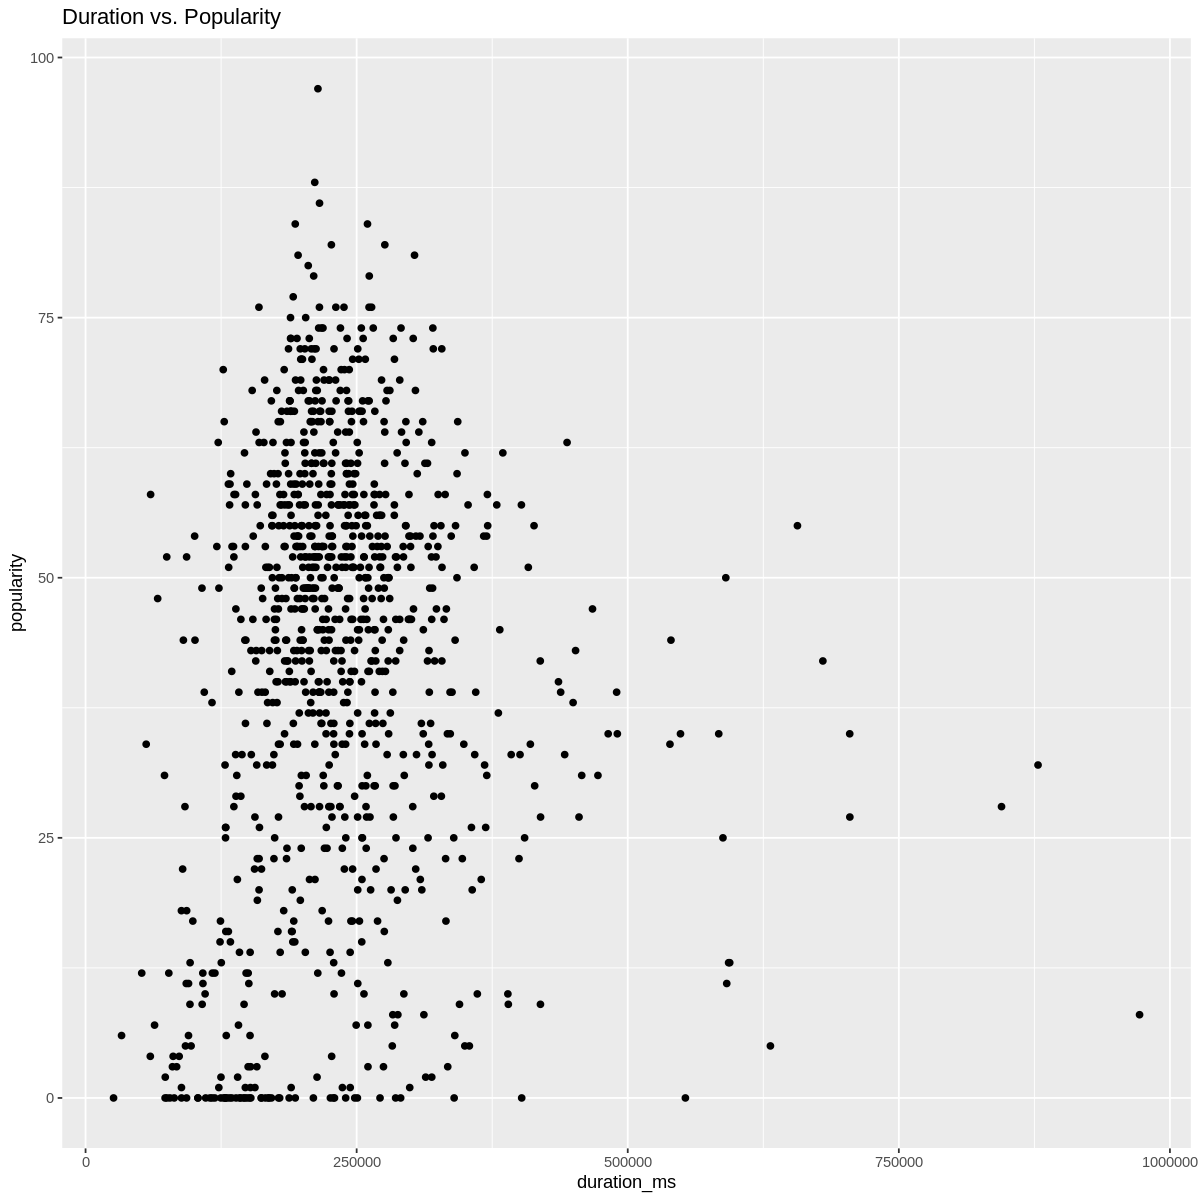

In [14]:
# Three Graphs
# popularity / danceability
# popularity / energy
# popularity / tempo (ms)

energy_plot = spotify_rs %>% ggplot(aes(x = energy, y = popularity)) +
                            geom_point() +
                            labs(xlab = "Energy", ylab = "Popularity") +
                            ggtitle("Energy vs. Popularity")

danceability_plot = spotify_rs %>% ggplot(aes(x = danceability, y = popularity)) +
                            geom_point() +
                            labs(xlab = "Danceability", ylab = "Popularity") +
                            ggtitle("Danceability vs. Popularity")

tempo_plot = spotify_rs %>% ggplot(aes(x = tempo, y = popularity)) +
                            geom_point() +
                            labs(xlab = "Tempo (ms)", ylab = "Popularity") +
                            ggtitle("Tempo vs. Popularity")

duration_plot = spotify_rs %>% ggplot(aes(x = duration_ms, y = popularity)) +
                            geom_point() +
                            labs(xlab = "Duration of Track", ylab = "Popularity") +
                            ggtitle("Duration vs. Popularity")
                            

energy_plot
                                   
tempo_plot
                                   
danceability_plot

duration_plot

## Part 3: Methods

**How will we coduct our data analysis?**

PLACEHOLDER

**Which variables are most important for our analysis?**

We expect to rely primarily on the following variables 
    qualitative columns
    - genre, artist_name, and track_name, as well as quantitative columns like danceability, energy, duration_ms, and tempo.

**How will we visualize results?**

As our prediction algorithm will be dealing with quantitative data, a scatterplot will be useful for visualizing the different datapoints within our dataset.

## Part 4: Expected Outcomes and Significance

**What do we expect to find?**

At first glance, we expect to find that new songs with higher ratings on both danceability and energy will likely score higher on popularity compared to songs that have lower ratings on these predictive variables. However, it will be interesting to dive further into this analysis and it our hope that our assumptions will be challenged and stretched.

**What impact could these findings have?**

Our findings could help artists and producers understand the metrics that make listeners really connect with a song. Making music is both an art and a science, and we hope that our analysis can provide artists and producers uncover insights to help them create new music that will resonate with listeners on Spotify and other streaming services.

**What future questions could this lead to?**

As this dataset is unique to the listening habits of Spotify users, it would be interesting to compare these results with data from other popular streaming services, like Apple Music, Amazon Music, and Youtube Music, respectively.